In [ ]:
!pip install scikit-learn
!pip install seaborn
!pip install matplotlib
!pip install SpeechRecognition
!pip install librosa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 35.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import sys
import csv
import urllib.request
import zipfile
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Embedding, Bidirectional, GRU, Dense
import librosa
import librosa.effects as le
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Audio
import speech_recognition as sr
import re
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
file_loc = ""
data_loc = "/content/drive/MyDrive/ALL/"
out_loc = file_loc+"/out"
Savee = file_loc + data_loc

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
emotion_map = {
    'h': 'happy',
    'sa': 'sad',
    'n': 'neutral',
    'a': 'angry',
    'd': 'disgust',
    'f': 'fear',
    'su': 'surprise'
}
file_emotion = []
file_path = []
savee_directory_list = os.listdir(Savee)
for file in savee_directory_list:
    file_path.append(Savee + file)
    file_emotion.append(emotion_map.get(file.split('_')[1][:-6])) #default=None if key not found


df_emotion = pd.DataFrame(file_emotion, columns=['emotion'])


df_path = pd.DataFrame(file_path, columns=['path'])


df_audio = pd.concat([df_emotion, df_path], axis=1)
df_audio.head()

emotion                                   path
0   angry  /content/drive/MyDrive/ALL/DC_a10.wav
1   angry  /content/drive/MyDrive/ALL/DC_a02.wav
2   angry  /content/drive/MyDrive/ALL/DC_a11.wav
3   angry  /content/drive/MyDrive/ALL/DC_a01.wav
4   angry  /content/drive/MyDrive/ALL/DC_a06.wav

In [ ]:
df_audio.emotion.astype('category')
print("Number of emotions available in the dataset : " + str(df_audio.emotion.nunique()))
list(df_audio.emotion.unique())

Number of emotions available in the dataset : 7


['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

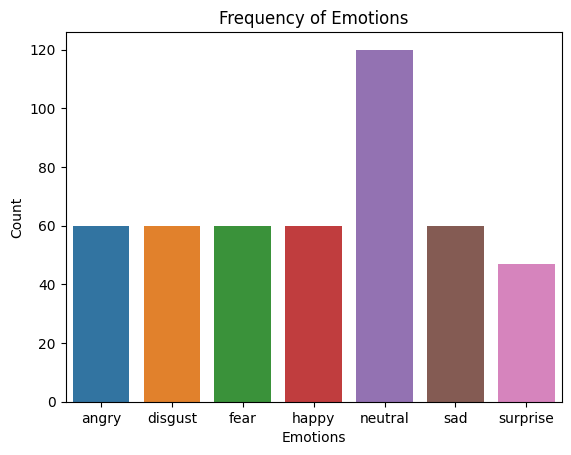

In [ ]:
sns.countplot(df_audio, x=df_audio.emotion)
plt.title('Frequency of Emotions')
plt.ylabel('Count')
plt.xlabel('Emotions')
plt.show()

In [ ]:
df_audio.emotion.value_counts()

neutral     120
angry        60
disgust      60
fear         60
happy        60
sad          60
surprise     47
Name: emotion, dtype: int64

In [ ]:
file_path = np.array(df_audio.iloc[5])[1]
Audio(file_path)

In [ ]:

file_path = np.array(df_audio.iloc[17])[1]
Audio(file_path)

In [ ]:
file_path = np.array(df_audio.iloc[50])[1]
Audio(file_path)

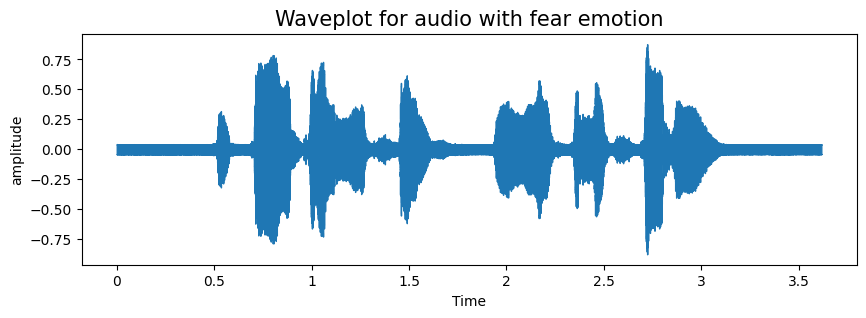

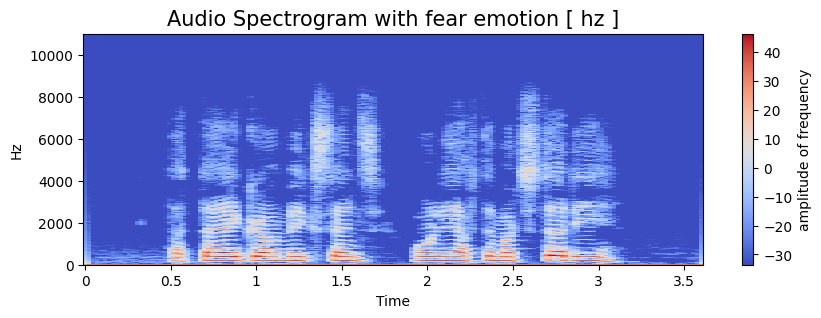

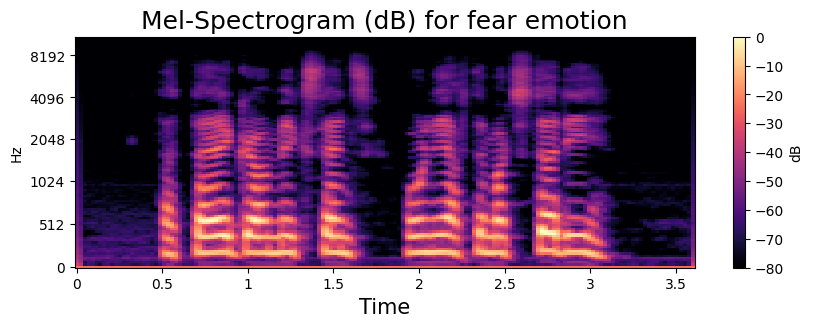

In [ ]:
def create_waveplot(data, sr, emo):
    '''
      creates waveplot from the data for the given sampling rate.
    '''
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(emo), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.ylabel('amplitude')
    plt.show()

def create_spectrogram(data, sr, emo, freq='hz'):
    #stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(10, 3))
    plt.title('Audio Spectrogram with {} emotion [ {} ]'.format(emo, freq), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis=freq)
    plt.colorbar(label='amplitude of frequency')
    plt.show()

def create_mel_spectrogram(data, sr, emo):
    '''
      creates mel-spectogram, which is perceptually relevant amplitude and frequency representation.
    '''
    mel_signal = librosa.feature.melspectrogram(y=data, sr=sr)
    spectrogram = np.abs(mel_signal)
    power_to_db = librosa.power_to_db(spectrogram, ref=np.max)
    plt.figure(figsize=(10, 3))
    librosa.display.specshow(power_to_db, sr=sr, x_axis='time', y_axis='mel', cmap='magma')
    plt.colorbar(label='dB')
    plt.title('Mel-Spectrogram (dB) for {} emotion'.format(emo), fontdict=dict(size=18))
    plt.xlabel('Time', fontdict=dict(size=15))

def plots_for_emotion(emotion):
  '''
    creates waveplot and spectogram for the mentioned emotion on our dataset
  '''
  select_instance = 1
  path = np.array(df_audio.path[df_audio.emotion==emotion])[select_instance]
  data, sampling_rate = librosa.load(path)
  create_waveplot(data, sampling_rate, emotion)
  create_spectrogram(data, sampling_rate, emotion,'hz')
  create_mel_spectrogram(data, sampling_rate, emotion)
  return Audio(path)


plots_for_emotion('fear')

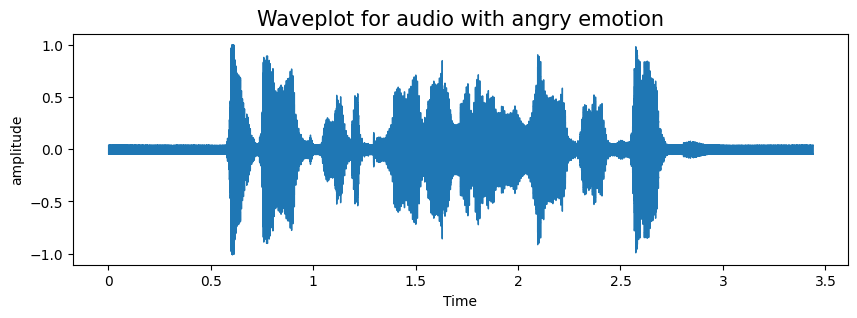

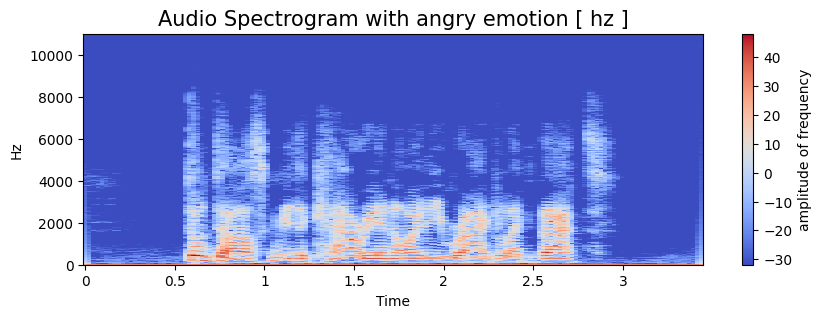

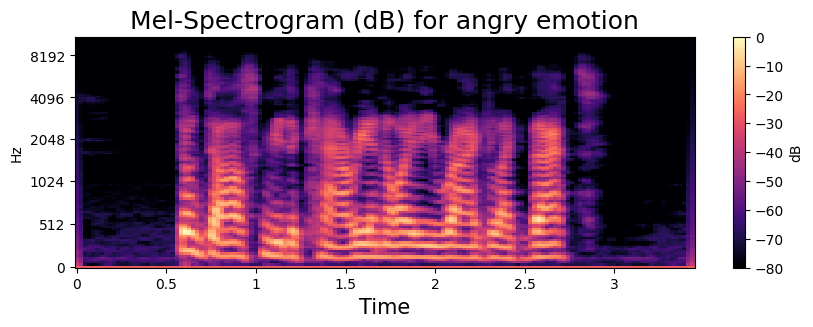

In [ ]:
plots_for_emotion('angry')

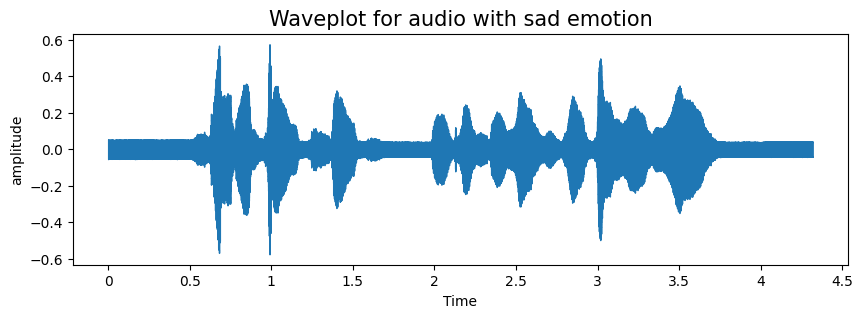

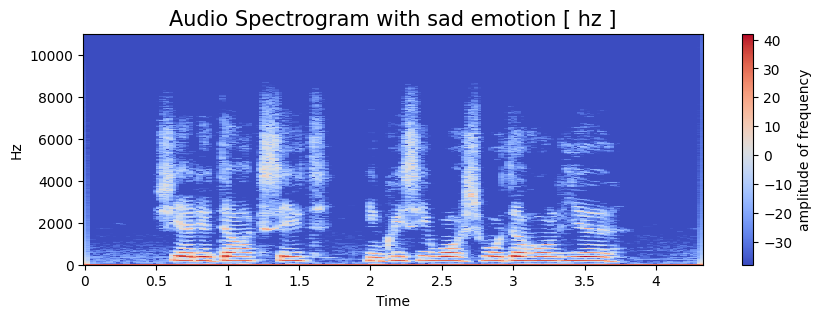

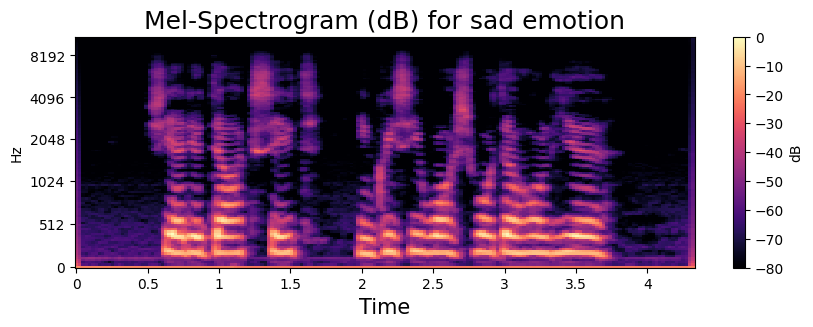

In [ ]:
plots_for_emotion('sad')

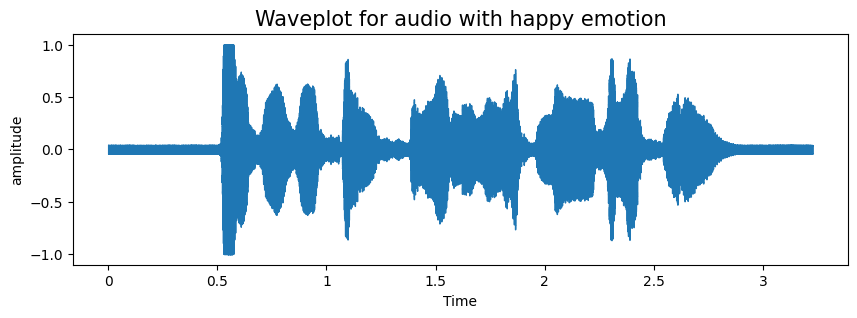

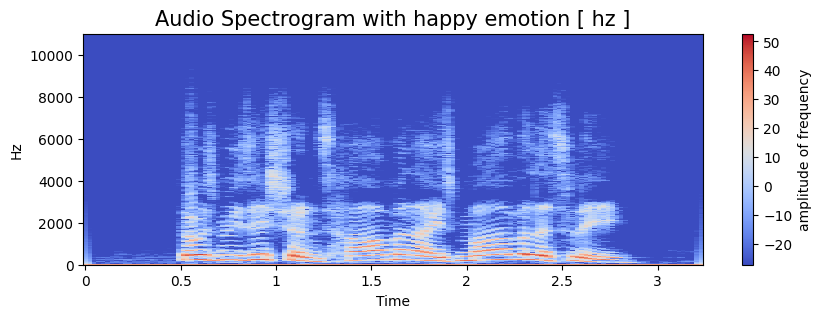

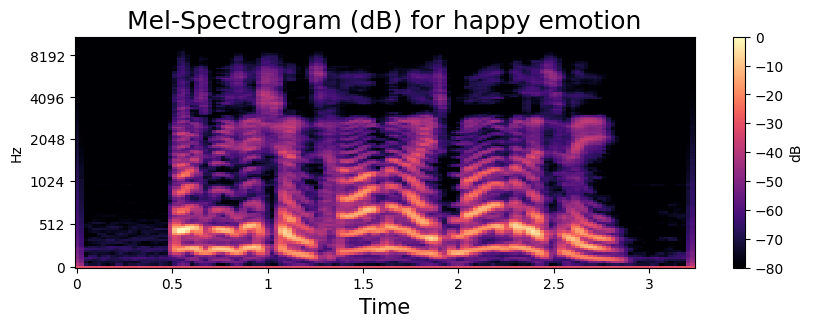

In [ ]:
plots_for_emotion('happy')

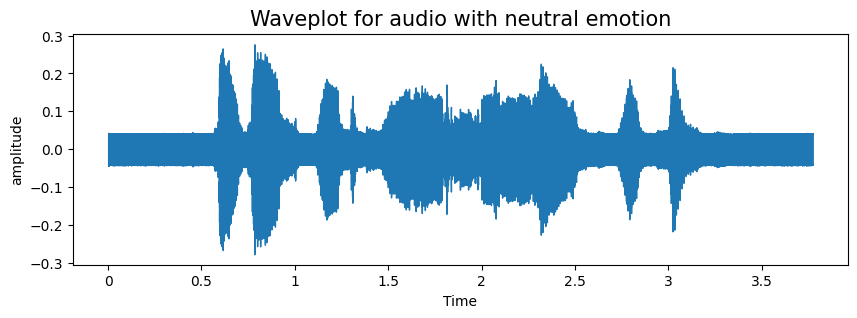

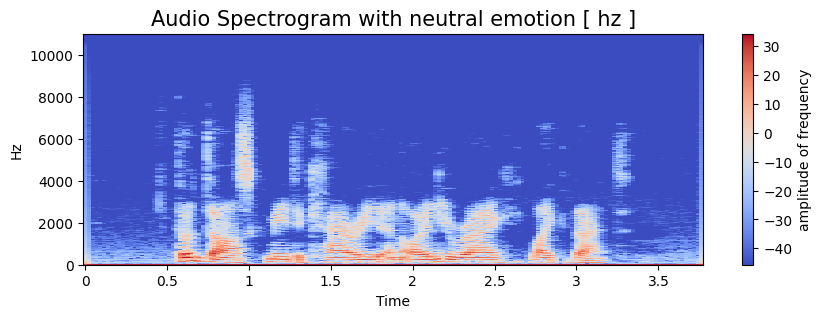

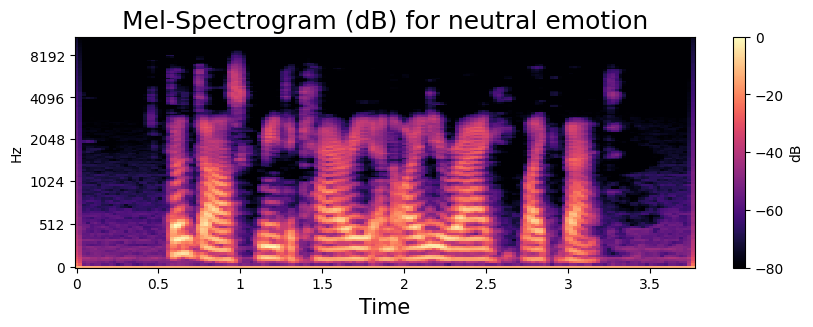

In [ ]:
plots_for_emotion('neutral')

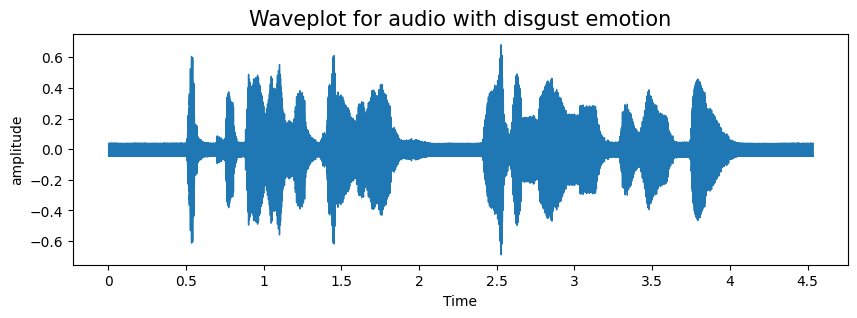

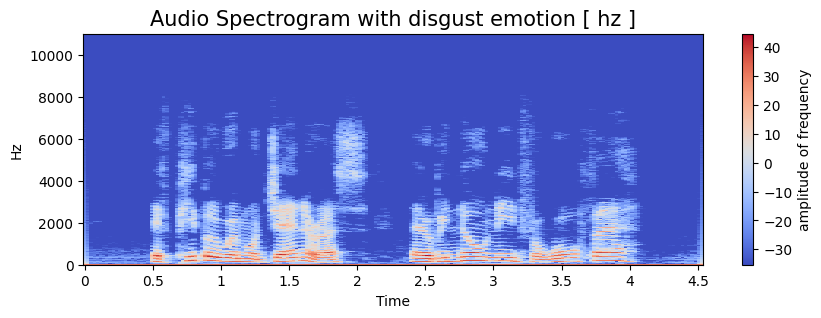

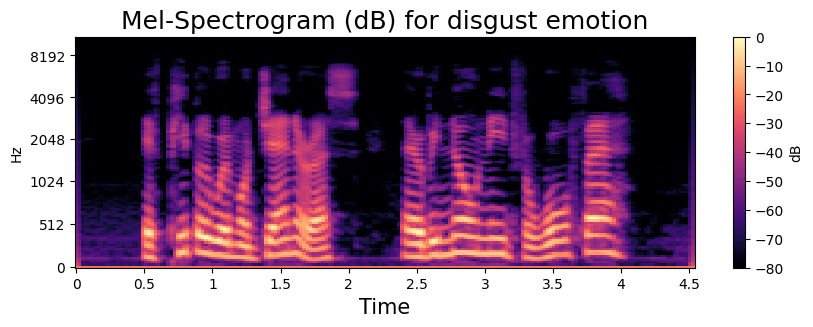

In [ ]:
plots_for_emotion('disgust')

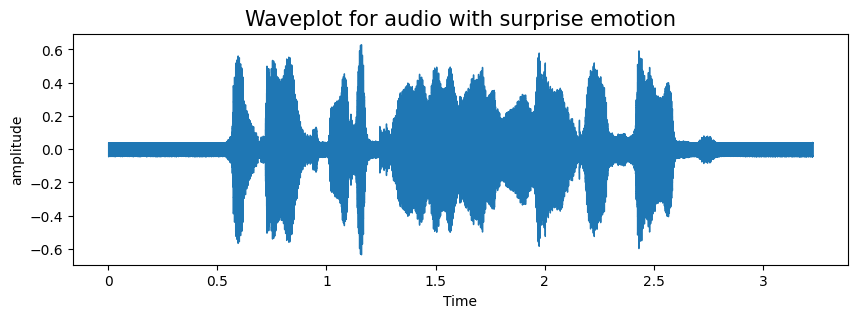

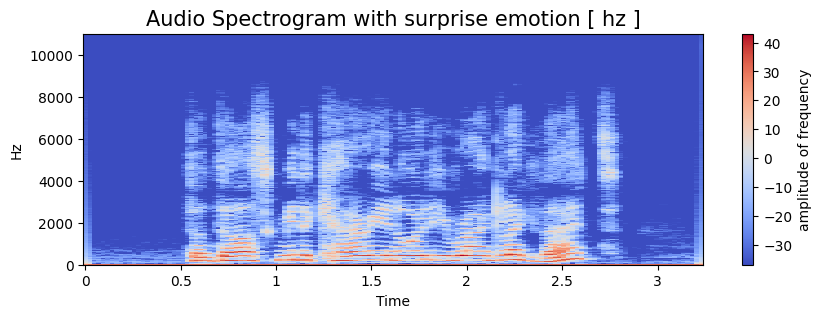

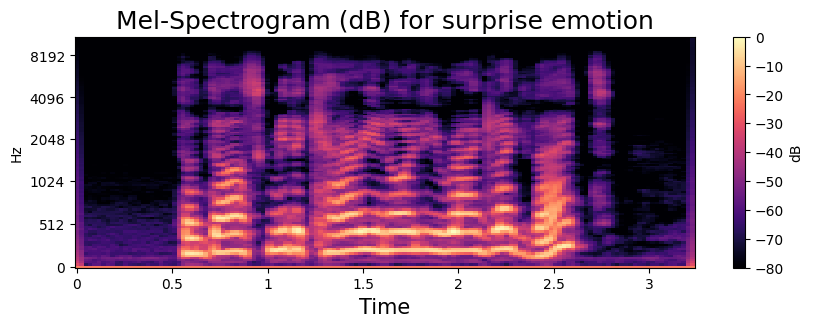

In [ ]:
plots_for_emotion('surprise')

In [ ]:
def noise(data):
    '''
      adds uniform noise to the data
    '''
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, srate=0.8):
    '''
      slows down audio without changing the pitch
    '''
    return le.time_stretch(data, rate=srate)

def shift(data):
    '''
      audio is randomly shifted left or right
    '''
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    '''
      shifts the pitch of the audio by pitch_factor
    '''
    return le.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

In [ ]:
def plot_waveform(data, sample_rate):
  '''
    outputs waveform for the given audio
  '''
  plt.figure(figsize=(10,3))
  plt.title("Waveform of audio")
  librosa.display.waveshow(y=data, sr=sample_rate)
  plt.ylabel('amplitude')
  plt.show()

#selecting random sample to check the result of the above techniques
path = np.array(df_audio.path)[1]
data, sample_rate = librosa.load(path)

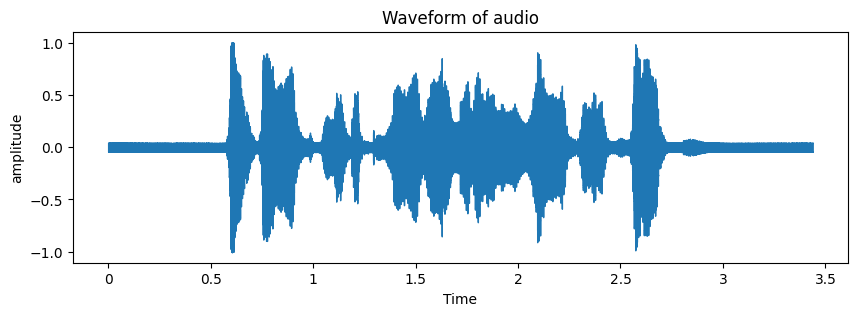

In [ ]:
plot_waveform(data,sample_rate)
Audio(data, rate=sample_rate)

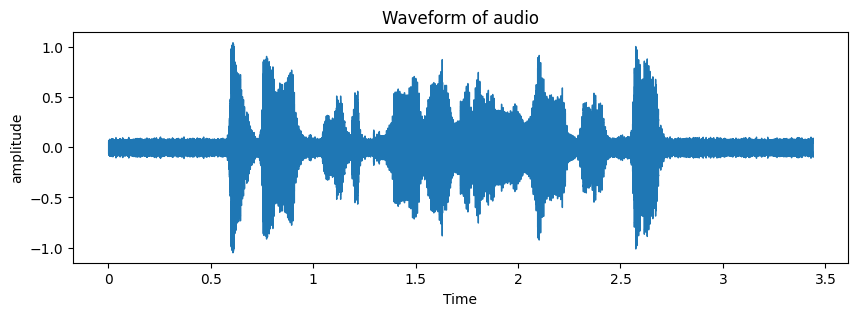

In [ ]:
x = noise(data)
plot_waveform(x,sample_rate)
Audio(x, rate=sample_rate)

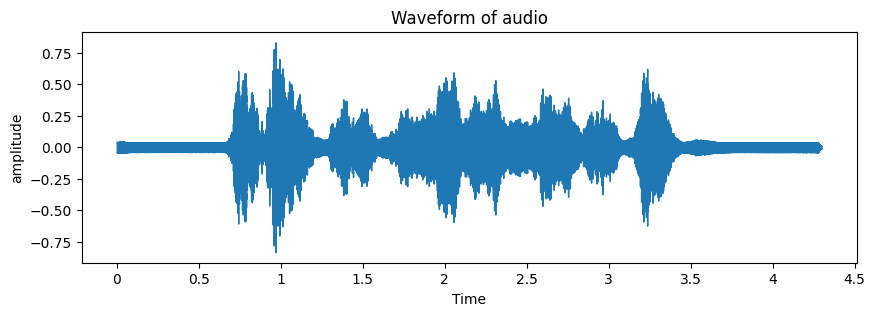

In [ ]:
x = stretch(data)
plot_waveform(x,sample_rate)
Audio(x, rate=sample_rate)

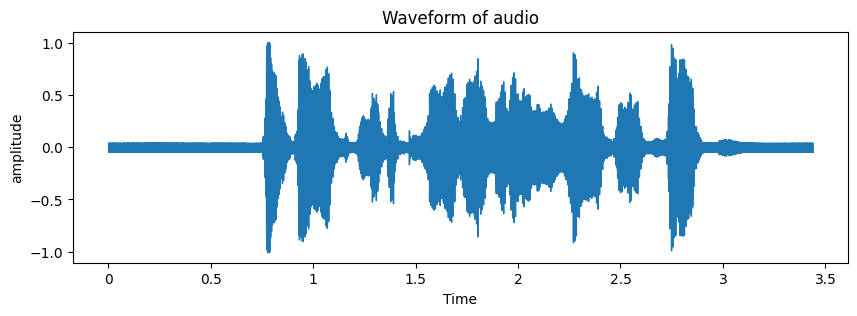

In [ ]:
x = shift(data)
plot_waveform(x,sample_rate )
Audio(x, rate=sample_rate)

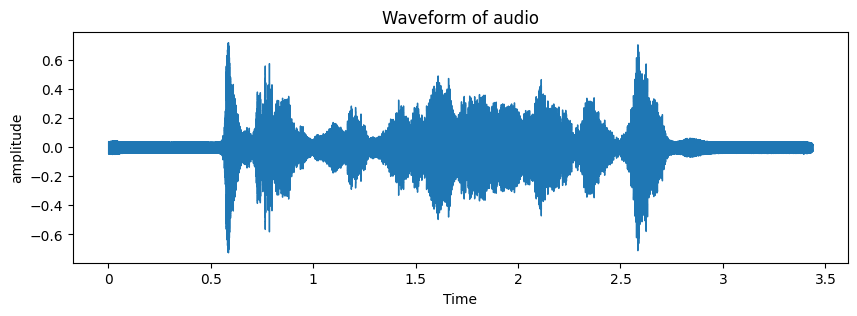

In [ ]:
x = pitch(data, sample_rate)
plot_waveform(x,sample_rate )
Audio(x, rate=sample_rate)

In [ ]:
def mler(rms):
    '''
     mler function is used to quantify the energy level of an audio signal relative to a set threshold value
    '''
    lef=0
    delta=0.06
    lowthresh=rms.mean()*delta
    for val in rms:
        lef+=np.sign(lowthresh-val)+1
    mler=lef/len(rms)
    return mler

def extract_features(data):
    '''
      this function extracts following features from the audio data
      - zcr
      - chroma stft
      - mfcc
      - rmse
      - mel spectogram mean
      - spectral centroid
      - spectral flux
      - chroma_cens
      - spectral roll off
    '''

    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    # spectral centroid
    spec_cent=np.mean(librosa.feature.spectral_centroid(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, spec_cent)) # stacking horizontally

    # spectral flux
    onset_env =np.mean( librosa.onset.onset_strength(sr=sample_rate, S=librosa.amplitude_to_db(data, ref=np.max)))
    result=np.hstack((result,onset_env))

    # mler
    Mler=mler(rms)
    result=np.hstack((result,Mler))

    # chroma_cens
    chroma_cens = np.mean(librosa.feature.chroma_cens(y=data, sr=sample_rate))
    result=np.hstack((result,chroma_cens))

    # spectral roll off
    spec_rolloff = np.mean(librosa.feature.spectral_rolloff(y=x, sr=sample_rate)[0])
    result=np.hstack((result,spec_rolloff))
    return result

def get_features(path):
    '''
      applying augmentation to the audio data
    '''

    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    res1 = extract_features(data)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically

    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically

    shifted_data = shift(data)

    return result

In [ ]:
if not os.path.isfile(out_loc+'/features.csv') :
  X, Y, Z = [], [], []
  for path, emotion in zip(df_audio.path, df_audio.emotion):
      feature = get_features(path)
      # appending emotion 3 times for 3 augmentation techniques on each audio file
      for ele in feature:
          X.append(ele)
          Y.append(emotion)
          Z.append(path)

  print("Original data size : " ,df_audio.path.shape[0])
  print('Augment data size  : ', len(X))

  # creating dataframe from extracted features
  df_features = pd.DataFrame(X)
  df_features['labels'] = Y
  df_features['path'] = Z

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=1024 is too large for input signal of length=862
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=1024 is too large for input signal of length=709
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=1024 is too large for input signal of length=887
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=1024 is too large for input signal of length=718
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=1024 is too large for input signal of length=898
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=1024 is too large for input signal of length=1017
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256:

In [ ]:
df_features.shape

(1401, 169)

Preparing Data for Modeling

In [ ]:
X = df_features.iloc[: ,:-2] #features
Y = df_features['labels'] #target
Y1 = df_features[['labels', 'path']] #target, path

#random state for train-test split
random_tts=11

Data-1 (with random distribution of classes)

In [ ]:
x_train, x_test, y_train1, y_test1 = train_test_split(X, Y1, random_state=random_tts, test_size=0.1)
x_train, x_val, y_train1, y_val = train_test_split(x_train, y_train1, random_state=random_tts, test_size=0.1)

print("Train set : ", x_train.shape, y_train1.shape)
print("Valdiation set: " , x_val.shape, y_val.shape)
print("Test set: ",  x_test.shape, y_test1.shape)

Train set :  (1134, 167) (1134, 2)
Valdiation set:  (126, 167) (126, 2)
Test set:  (141, 167) (141, 2)


In [ ]:
y_train1['labels'].value_counts()

neutral     292
angry       151
happy       147
sad         145
fear        144
disgust     142
surprise    113
Name: labels, dtype: int64

In [ ]:
y_val['labels'].value_counts()

neutral     29
angry       20
happy       18
fear        18
disgust     17
sad         13
surprise    11
Name: labels, dtype: int64

In [ ]:
y_test1['labels'].value_counts()

neutral     39
sad         22
disgust     21
fear        18
surprise    17
happy       15
angry        9
Name: labels, dtype: int64

In [ ]:
encoder = OneHotEncoder()
y_train = encoder.fit_transform(np.array(y_train1['labels']).reshape(-1,1)).toarray()
y_val = encoder.transform(np.array(y_val['labels']).reshape(-1,1)).toarray()
y_test = encoder.transform(np.array(y_test1['labels']).reshape(-1,1)).toarray()

#Normalizing numeric values
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

print("Train set : ", x_train.shape, y_train1.shape)
print("Valdiation set: " , x_val.shape, y_val.shape)
print("Test set: ",  x_test.shape, y_test1.shape)

Train set :  (1134, 167) (1134, 2)
Valdiation set:  (126, 167) (126, 7)
Test set:  (141, 167) (141, 2)


In [ ]:
x_train = np.expand_dims(x_train, axis=2)
x_val = np.expand_dims(x_val, axis=2)
x_test = np.expand_dims(x_test, axis=2)

print("Train set : ", x_train.shape)
print("Valdiation set: " , x_val.shape)
print("Test set: ",  x_test.shape)

Train set :  (1134, 167, 1)
Valdiation set:  (126, 167, 1)
Test set:  (141, 167, 1)


Data-2 (with stratification)

In [ ]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(X, Y1, random_state=random_tts, stratify=Y,test_size=0.1)
x_train2, x_val2, y_train2, y_val2 = train_test_split(x_train2, y_train2, random_state=random_tts, test_size=0.1, stratify=y_train2['labels'])

print("Train set : ", x_train2.shape, y_train2.shape)
print("Valdiation set: " , x_val2.shape, y_val2.shape)
print("Test set: ",  x_test2.shape, y_test2.shape)

Train set :  (1134, 167) (1134, 2)
Valdiation set:  (126, 167) (126, 2)
Test set:  (141, 167) (141, 2)


In [ ]:
y_train2['labels'].value_counts()

neutral     290
disgust     146
angry       146
sad         146
fear        146
happy       146
surprise    114
Name: labels, dtype: int64

In [ ]:
y_val2['labels'].value_counts()

neutral     33
disgust     16
sad         16
angry       16
fear        16
happy       16
surprise    13
Name: labels, dtype: int64

In [ ]:
y_test2['labels'].value_counts()

neutral     37
disgust     18
happy       18
fear        18
sad         18
angry       18
surprise    14
Name: labels, dtype: int64

In [ ]:
encoder = OneHotEncoder()
y_train2 = encoder.fit_transform(np.array(y_train2['labels']).reshape(-1,1)).toarray()
y_val2 = encoder.transform(np.array(y_val2['labels']).reshape(-1,1)).toarray()
y_test2 = encoder.transform(np.array(y_test2['labels']).reshape(-1,1)).toarray()

#Normalizing numeric values
scaler = StandardScaler()
x_train2 = scaler.fit_transform(x_train2)
x_val2 = scaler.transform(x_val2)
x_test2 = scaler.transform(x_test2)

#Adding extra dimension for 1D CNN
#3rd dimension will be set to 1
x_train2 = np.expand_dims(x_train2, axis=2)
x_val2 = np.expand_dims(x_val2, axis=2)
x_test2 = np.expand_dims(x_test2, axis=2)

print("Train set : ", x_train2.shape, y_train2.shape)
print("Valdiation set: " , x_val2.shape, y_val2.shape)
print("Test set: ",  x_test2.shape, y_test2.shape)

Train set :  (1134, 167, 1) (1134, 7)
Valdiation set:  (126, 167, 1) (126, 7)
Test set:  (141, 167, 1) (141, 7)


CNN (1D) Model


In [ ]:
 def create_model (x_train) :
  model=Sequential()

  #layer1
  model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
  model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

  #layer2
  model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
  model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

  #layer3
  model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
  model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
  model.add(Dropout(0.2))

  #layer4
  model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
  model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

  model.add(Flatten())
  model.add(Dense(units=32, activation='relu'))
  model.add(Dropout(0.3))

  model.add(Dense(units=7, activation='softmax'))
  model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

  return model

Training the model using Data-1

In [ ]:
model=create_model(x_train)
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_18 (Conv1D)          (None, 167, 256)          1536      
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 84, 256)          0         
 1D)                                                             
                                                                 
 conv1d_19 (Conv1D)          (None, 84, 256)           327936    
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 42, 256)          0         
 g1D)                                                            
                                                                 
 conv1d_20 (Conv1D)          (None, 42, 128)           163968    
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 21, 128)         

In [ ]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_val, y_val), callbacks=[rlrp])
model.save(out_loc+'/models/audioAnalysisData1.h5')

Epoch 1/50
18/18 [==============================] - 11s 481ms/step - loss: 1.8202 - accuracy: 0.3139 - val_loss: 1.7421 - val_accuracy: 0.3254 - lr: 0.0010
Epoch 2/50
18/18 [==============================] - 9s 524ms/step - loss: 1.6628 - accuracy: 0.3422 - val_loss: 1.6674 - val_accuracy: 0.3492 - lr: 0.0010
Epoch 3/50
18/18 [==============================] - 7s 398ms/step - loss: 1.5591 - accuracy: 0.3730 - val_loss: 1.5850 - val_accuracy: 0.3413 - lr: 0.0010
Epoch 4/50
18/18 [==============================] - 9s 530ms/step - loss: 1.5035 - accuracy: 0.3836 - val_loss: 1.5397 - val_accuracy: 0.3571 - lr: 0.0010
Epoch 5/50
18/18 [==============================] - 7s 408ms/step - loss: 1.4635 - accuracy: 0.3968 - val_loss: 1.5140 - val_accuracy: 0.3730 - lr: 0.0010
Epoch 6/50
18/18 [==============================] - 12s 657ms/step - loss: 1.4201 - accuracy: 0.4074 - val_loss: 1.4890 - val_accuracy: 0.3889 - lr: 0.0010
Epoch 7/50
18/18 [==============================] - 7s 395ms/step - 

In [ ]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)
y_test = encoder.inverse_transform(y_test)

print(classification_report(y_test, y_pred))


5/5 [==============================] - 0s 42ms/step
              precision    recall  f1-score   support

       angry       0.35      0.67      0.46         9
     disgust       0.65      0.52      0.58        21
        fear       0.61      0.61      0.61        18
       happy       0.60      0.60      0.60        15
     neutral       0.83      0.74      0.78        39
         sad       0.80      0.91      0.85        22
    surprise       0.93      0.76      0.84        17

    accuracy                           0.70       141
   macro avg       0.68      0.69      0.68       141
weighted avg       0.73      0.70      0.71       141



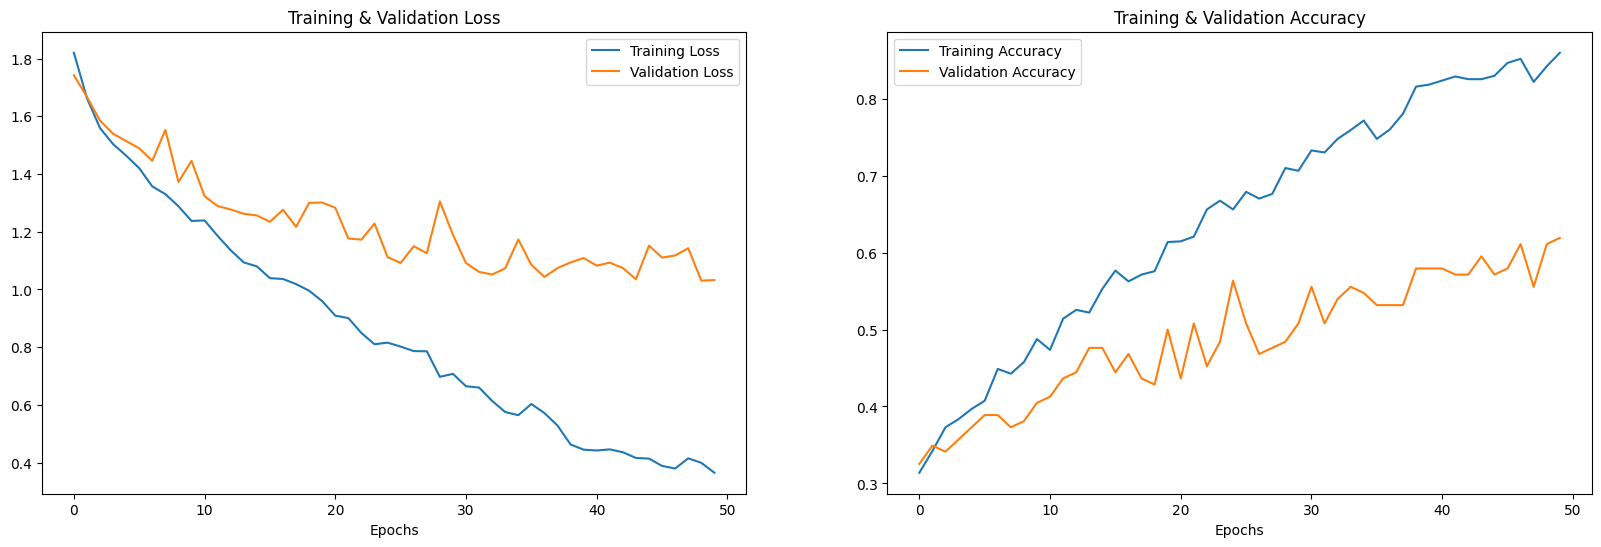

In [ ]:
epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , val_loss , label = 'Validation Loss')
ax[0].set_title('Training & Validation Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , val_acc , label = 'Validation Accuracy')
ax[1].set_title('Training & Validation Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
def generate_confusion_matrix(y_test, y_pred):
  labels=[l for l in encoder.categories_[0]]
  cf_matrix = confusion_matrix(y_test,y_pred)
  cm = pd.DataFrame(cf_matrix , index = [i for i in labels] , columns = [i for i in labels])
  ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt="d")
  ax.set_title('Confusion Matrix');
  ax.set_xlabel('Predicted Values')
  ax.set_ylabel('Actual Values ')
  plt.show()

In [ ]:
print("Accuracy of our model on train data : " , model.evaluate(x_train,y_train)[1]*100 , "%")

36/36 [==============================] - 3s 82ms/step - loss: 0.2046 - accuracy: 0.9436
Accuracy of our model on train data :  94.35626268386841 %


In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

5/5 [==============================] - 0s 39ms/step - loss: 0.8436 - accuracy: 0.7021
Accuracy of our model on test data :  70.21276354789734 %


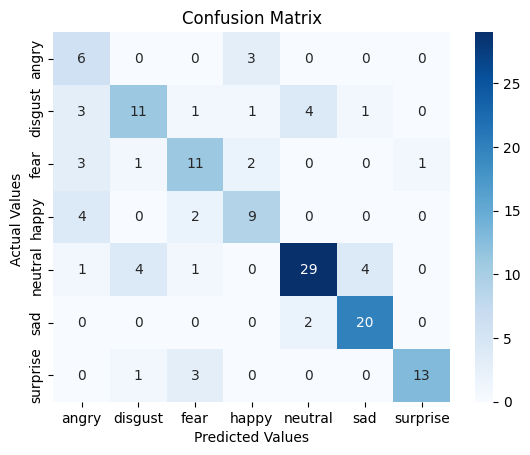

In [ ]:
generate_confusion_matrix(y_test, y_pred)